In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Conv2D, Lambda, MaxPooling2D, concatenate, Conv2DTranspose, Dense, UpSampling2D
from tensorflow.keras.models import Model, load_model
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import os
from glob import glob
from tqdm import tqdm

In [2]:
"""Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR 해결 책."""
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
#gpu 메모리 할당 문제....

In [3]:
MAIN_PATH = './data/finding-lungs-in-ct-data/'
IMG_PATH = os.path.join(MAIN_PATH, '2d_images')
MASK_PATH = os.path.join(MAIN_PATH, '2d_masks')

In [4]:
IMG_LIST = sorted(glob(os.path.join(IMG_PATH, '*.tif')))
MASK_LIST = sorted(glob(os.path.join(MASK_PATH, '*.tif')))

print("2d_images 파일 개수 : ", len(IMG_LIST))
print("2d_masks 파일 개수 : ", len(MASK_LIST))

2d_images 파일 개수 :  267
2d_masks 파일 개수 :  267


In [5]:
IMG_HEIGHT = 256
IMG_WEIGHT = 256

train_images = np.zeros((len(IMG_LIST), IMG_WEIGHT, IMG_HEIGHT, 1), dtype=np.float32)
train_labels = np.zeros((len(IMG_LIST), IMG_WEIGHT, IMG_HEIGHT, 1), dtype=np.float32)

In [6]:
print(train_images.shape)
print(train_labels.shape)

(267, 256, 256, 1)
(267, 256, 256, 1)


In [7]:
for i, path in tqdm(enumerate(IMG_LIST), total=len(IMG_LIST)):
    img = imread(path)
    img = resize(img, (IMG_HEIGHT, IMG_WEIGHT, 1), mode='constant', preserve_range=True)
    train_images[i] = img
for i, path in tqdm(enumerate(MASK_LIST), total=len(MASK_LIST)):
    img = imread(path)
    img = resize(img, (IMG_HEIGHT, IMG_WEIGHT, 1), mode='constant', preserve_range=True)
    train_labels[i] = img

100%|██████████| 267/267 [00:01<00:00, 233.75it/s]


In [8]:
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.1)

In [9]:
print("train_images Max Value :", train_images[0].max())
print("train_images Min Value : ", train_images[0].min())
print("train_labels Max Value :", train_labels[0].max())
print("train_labels Min Value :", train_labels[0].min())  

train_images Max Value : 960.25
train_images Min Value :  -2566.5
train_labels Max Value : 255.0
train_labels Min Value : 0.0


In [10]:
#Mask를 0 ~255 값을 0 ~ 1 로 Normalization을 해줌 (무조건 0` ~ 1이 아니고 조금 벗어날수도 있음.)
train_labels /= 255.
print("train_labels Max Value :", train_labels[0].max())
print("train_labels Min Value :", train_labels[0].min())  

train_labels Max Value : 1.0
train_labels Min Value : 0.0


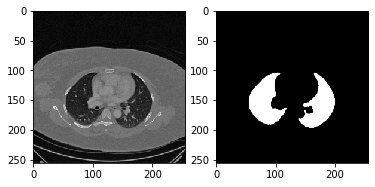

In [11]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_images[20].squeeze(), cmap='gray')
ax[1].imshow(train_labels[20].squeeze(), cmap='gray')

In [12]:
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.1)
valid_images,test_images,valid_labels, test_labels = train_test_split(valid_images, valid_labels, test_size=0.1)

In [13]:
print(train_images.shape) # Batch, Width, Height, channel
print(train_labels.shape)
print(valid_images.shape)
print(valid_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(216, 256, 256, 1)
(216, 256, 256, 1)
(21, 256, 256, 1)
(21, 256, 256, 1)
(3, 256, 256, 1)
(3, 256, 256, 1)


In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=10000).batch(32)
validation_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels)).shuffle(buffer_size = 10000).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(buffer_size = 10000).batch(1)

In [15]:

inputs = Input(shape=(256, 256, 1))

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

W0904 13:39:43.121745 139941779695424 deprecation.py:506] From /home/mulkong/anaconda3/envs/mulkong/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0     

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

W0904 13:39:43.249318 139941779695424 deprecation.py:323] From /home/mulkong/anaconda3/envs/mulkong/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-Lung_segmentation.h5', verbose=1, save_best_only=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau

history = model.fit(train_dataset, validation_data=validation_dataset, epochs=100,callbacks=[
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05),
    checkpointer
])


Epoch 1/100
6/7 [========================>.....] - ETA: 0s - loss: 0.6303 - acc: 0.6644 - mean_squared_error: 0.2071
Epoch 00001: val_loss improved from inf to 0.55776, saving model to model-Lung_segmentation.h5
7/7 [==============================] - 8s 1s/step - loss: 0.6169 - acc: 0.6746 - mean_squared_error: 0.2034 - val_loss: 0.5578 - val_acc: 0.7549 - val_mean_squared_error: 0.1826
Epoch 2/100
6/7 [========================>.....] - ETA: 0s - loss: 0.5433 - acc: 0.7487 - mean_squared_error: 0.1778
Epoch 00002: val_loss improved from 0.55776 to 0.51024, saving model to model-Lung_segmentation.h5
7/7 [==============================] - 1s 127ms/step - loss: 0.5424 - acc: 0.7473 - mean_squared_error: 0.1779 - val_loss: 0.5102 - val_acc: 0.7593 - val_mean_squared_error: 0.1657
Epoch 3/100
6/7 [========================>.....] - ETA: 0s - loss: 0.5097 - acc: 0.7473 - mean_squared_error: 0.1657
Epoch 00003: val_loss improved from 0.51024 to 0.48366, saving model to model-Lung_segmentation.

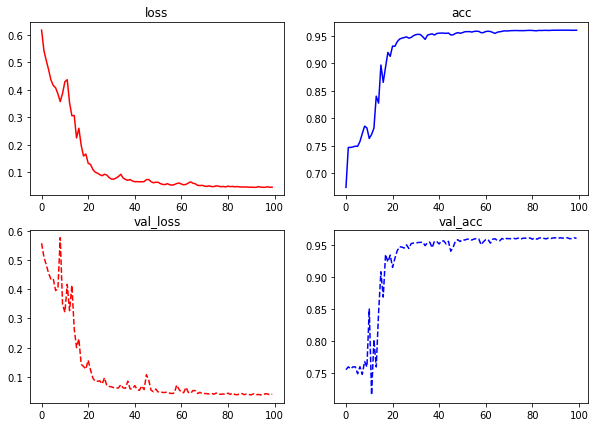

In [18]:

fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['acc'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_acc'], 'b--')

In [19]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.028305495157837868
Test accuracy: 0.9700826


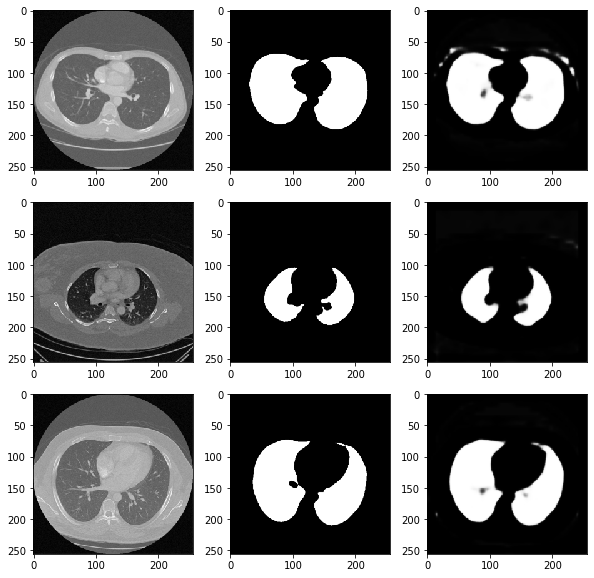

In [20]:

preds = model.predict(test_images)
test_images
fig, ax = plt.subplots(len(test_images), 3, figsize=(10, 10))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(test_images[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(test_labels[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')